In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.table import Table

In [2]:
filepath = '/Users/jimenagonzalez/research/DSPL/Hybrid_SL_Modeling/data/candidates_tocompare/final_files/'

#Rojas candidates 
hdu_list = fits.open(filepath + 'Rojas_DES.fits')
images = hdu_list[1].data.astype(np.float32)
data = Table(hdu_list[2].data).to_pandas() #Data is not complete here, just in the right sort
hdu_list.close()

print('Number candidates modeled: ', len(data))
data.columns

Number candidates modeled:  59


Index(['COADD_OBJECT_ID', 'TILENAME', 'HPIX_4096', 'RA', 'DEC', 'Name',
       'Exp_score', 'n_Cand', 'rchi2', 'RE', 'U_RE', 'L_RE', 'qm', 'U_qm',
       'L_qm', 'PAm', 'U_PAm', 'L_PAm', 'gammaext', 'U_gammaext', 'L_gammaext',
       'phiext', 'U_phiext', 'L_phiext'],
      dtype='object')

In [3]:
theta = np.deg2rad(data['PAm'])   # position angle in radians

e = (1 - data['qm']) / (1 + data['qm'])

data['e1'] = e * np.cos(2 * theta)
data['e2'] = e * np.sin(2 * theta)

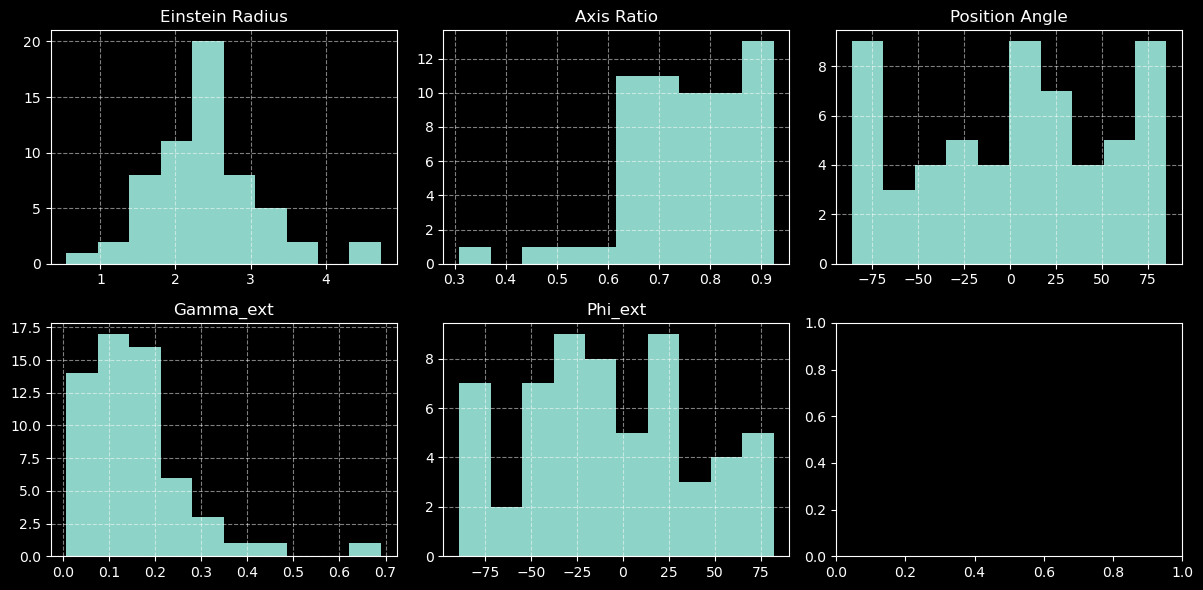

In [4]:
modeling_param = {'RE': 'Einstein Radius', 'qm': 'Axis Ratio', 'PAm': 'Position Angle', 'gammaext': 'Gamma_ext', 
                   'phiext': 'Phi_ext'}

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, (key, label) in zip(axes, modeling_param.items()):
    ax.hist(data[key])
    ax.set_title(label)
    ax.grid(which='both',  linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

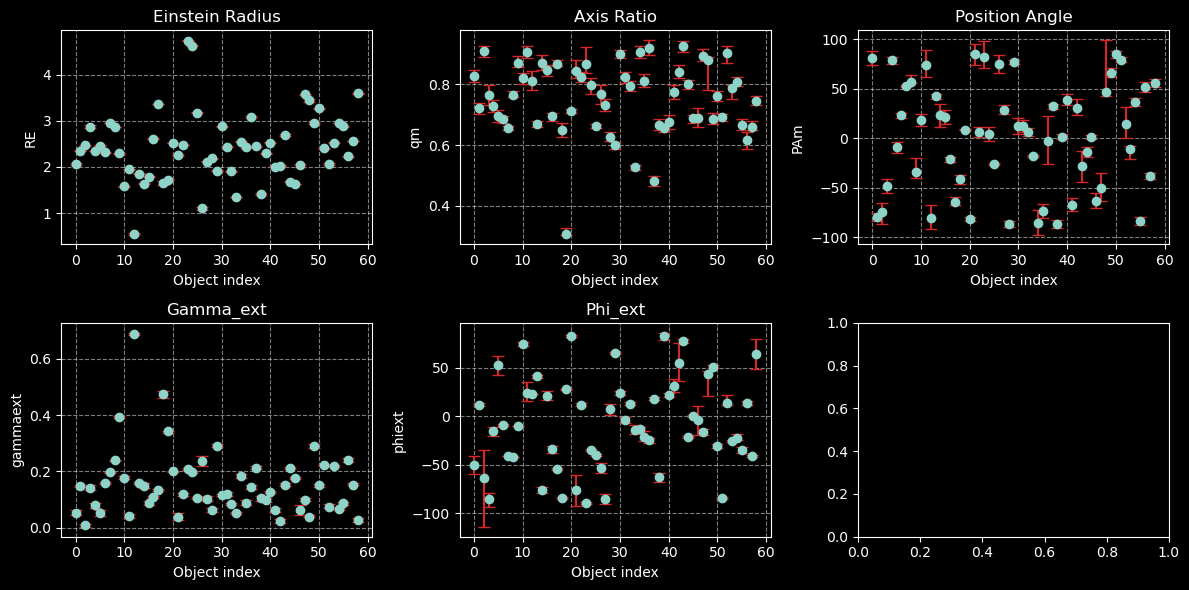

In [5]:
modeling_param2 = {'Einstein Radius': ['RE', 'U_RE', 'L_RE'], 'Axis Ratio': ['qm', 'U_qm', 'L_qm'], 
                  'Position Angle': ['PAm', 'U_PAm', 'L_PAm'],  'Gamma_ext': ['gammaext', 'U_gammaext', 'L_gammaext'], 
                    'Phi_ext': ['phiext', 'U_phiext', 'L_phiext']}


fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, (key, label) in zip(axes, modeling_param2.items()):
    
    label = key
    best_col, up_col, low_col = modeling_param2[label]

    y = data[best_col].to_numpy()
    yerr_low = data[low_col].to_numpy()
    yerr_up  = data[up_col].to_numpy() 

    x = np.arange(len(data))

    ax.errorbar(x, y, yerr=[yerr_low, yerr_up], fmt='o', capsize=4, ecolor='tab:red')
    #plt.ylim(-1, 5)
    ax.set_title(label)
    ax.set_xlabel("Object index")
    ax.set_ylabel(best_col)
    ax.grid(which='both',  linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.show() 

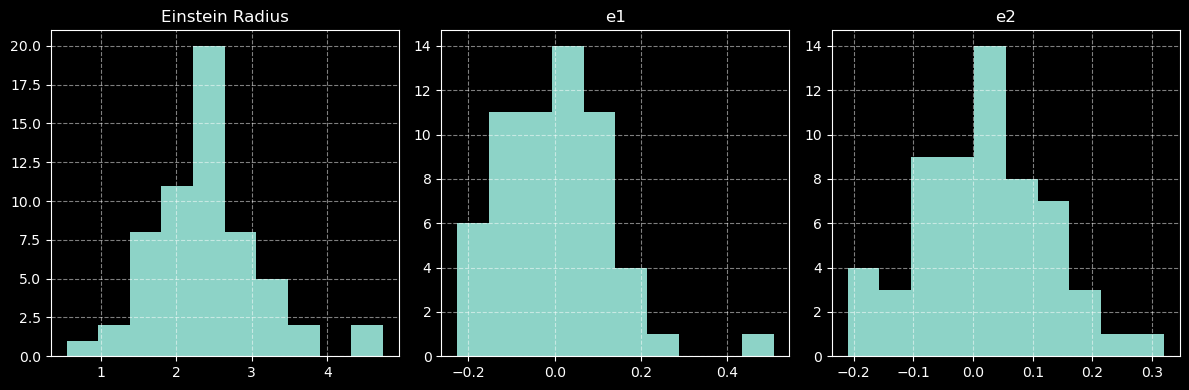

In [6]:
#Ellipticity
modeling_param = {'RE': 'Einstein Radius', 'e1': 'e1', 'e2': 'e2'}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for ax, (key, label) in zip(axes, modeling_param.items()):
    ax.hist(data[key])
    ax.set_title(label)
    ax.grid(which='both',  linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [7]:
#Propagation errors properly for ellipticity components
def e1_from_q_theta(q, theta):
    e = (1 - q) / (1 + q)
    e1 = e * np.cos(2 * theta)
    e2 = e * np.sin(2 * theta)
    return e1

def e2_from_q_theta(q, theta):
    e = (1 - q) / (1 + q)
    e1 = e * np.cos(2 * theta)
    e2 = e * np.sin(2 * theta)
    return e2

q  = data['qm'].to_numpy()
qU = data['U_qm'].to_numpy() + q
qL = q - data['L_qm'].to_numpy()

theta  = np.deg2rad(data['PAm'].to_numpy())
thetaU = theta + np.deg2rad(data['U_PAm'].to_numpy())
thetaL = theta - np.deg2rad(data['L_PAm'].to_numpy())

e1 = e1_from_q_theta(q, theta) #Central values
e2 = e2_from_q_theta(q, theta) #Central values

e1_candidates = np.vstack([e1_from_q_theta(qU, thetaU), e1_from_q_theta(qU, thetaL),
    e1_from_q_theta(qL, thetaU), e1_from_q_theta(qL, thetaL), ])
e2_candidates = np.vstack([e2_from_q_theta(qU, thetaU), e2_from_q_theta(qU, thetaL),
    e2_from_q_theta(qL, thetaU), e2_from_q_theta(qL, thetaL), ])

U_e1 = np.max(e1_candidates, axis=0) - e1
L_e1 = e1 - np.min(e1_candidates, axis=0)
U_e2 = np.max(e2_candidates, axis=0) - e2
L_e2 = e2 - np.min(e2_candidates, axis=0)

data['e1']   = e1
data['U_e1'] = U_e1 
data['L_e1'] = L_e1 
data['e2']   = e2
data['U_e2'] = U_e2 
data['L_e2'] = L_e2 

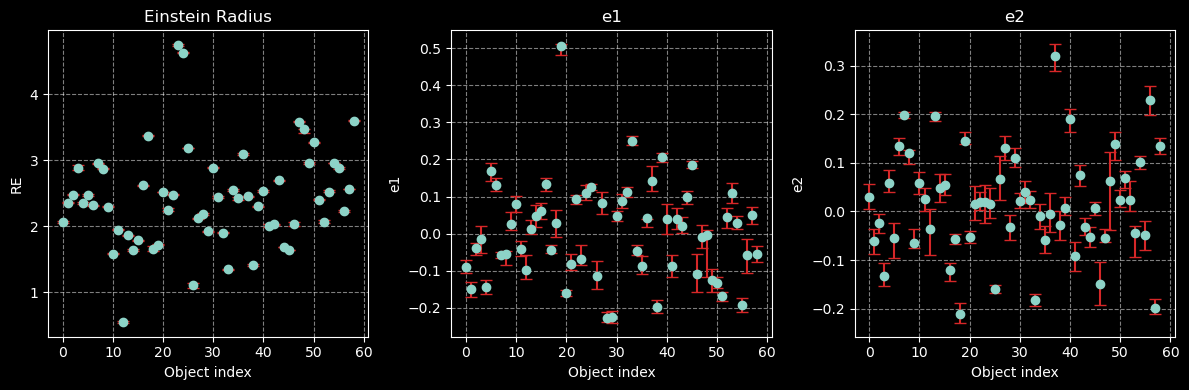

In [8]:
modeling_param2 = {'Einstein Radius': ['RE', 'U_RE', 'L_RE'], 'e1': ['e1', 'U_e1', 'L_e1'],
                  'e2': ['e2', 'U_e2', 'L_e2']}


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for ax, (key, label) in zip(axes, modeling_param2.items()):
    
    label = key
    best_col, up_col, low_col = modeling_param2[label]

    y = data[best_col].to_numpy()
    yerr_low = data[low_col].to_numpy()
    yerr_up  = data[up_col].to_numpy() 

    x = np.arange(len(data))

    ax.errorbar(x, y, yerr=[yerr_low, yerr_up], fmt='o', capsize=4, ecolor='tab:red')
    ax.set_title(label)
    ax.set_xlabel("Object index")
    ax.set_ylabel(best_col)
    ax.grid(which='both',  linestyle='--', alpha=0.5)        
    
plt.tight_layout()
plt.show() 